In [1]:
# Load the TensorBoard notebook extension
#%load_ext tensorboard
#%reload_ext tensorboard
!kill $(ps aux | grep './ngrok' | awk '{print $2}')

In [2]:
import os
import tensorflow as tf
from ResNet50 import *
from LoadDataset import *
from tensorboard import notebook
#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
#os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

#config = tf.compat.v1.ConfigProto()
#config.gpu_options.allow_growth = True

In [3]:
a = tf.Variable(2)
tf.print(a)
if tf.test.gpu_device_name(): 
    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))

else:
   print("Please install GPU version of TF")

2
Default GPU Device:/device:GPU:0


In [4]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import numpy as np
import matplotlib.pyplot as plt
import datetime

from tensorflow.keras.layers import Dense, Flatten, Conv2D, Reshape
from tensorflow.keras import Model
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import tensorflow.keras.backend as K
from Squeeze_and_Excite import Squeeze_and_Excite 
from ResNet50 import *
from LoadDataset import *

#%load_ext tensorboard
#!rm -rf ./logs/

epoch = 2
batch_size = 32
learning_rate = 0.01
dataset = 10


def oneHotEncoder(data):
    label_encoder = LabelEncoder()
    values = np.array(data)
    onehot_encoder = OneHotEncoder(sparse = False)
    integer_encoded = label_encoder.fit_transform(values)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
    return onehot_encoded

loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer_sgd = tf.keras.optimizers.SGD(learning_rate=learning_rate)
optimizer_adam = tf.keras.optimizers.Adam(learning_rate=0.01)
optimizer = optimizer_adam


train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')
test_top1 = tf.keras.metrics.SparseTopKCategoricalAccuracy(k=1, name='test_1_accuracy') 
test_top5 = tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5, name='test_5_accuracy') 

@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
    # training=True is only needed if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
        predictions = model(images, training = True)
        loss =loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    train_loss(loss)
    train_accuracy(labels, predictions)
        
@tf.function
def test_step(images, labels):
    # training=True is only needed if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    predictions = model(images, training = False)
    t_loss =loss_object(labels, predictions)

    test_loss(t_loss)
    test_accuracy(labels, predictions)
    test_top1(labels, predictions)
    test_top5(labels, predictions)


if __name__ == "__main__":

    save_model_dir = "./checkpoints_norm"

    print("loading data 2...")
    train_X, train_lab, test_X, test_lab = get_data(dataset)
    print("normalizing data...")
    train_X, test_X = normalize(train_X, test_X)
    train_data = tf.data.Dataset.from_tensor_slices((train_X, train_lab)).batch(batch_size)
    test_data = tf.data.Dataset.from_tensor_slices((test_X, test_lab)).batch(batch_size)
    

    #model = ResNet50(include_top=True, weights=None, squeeze=False, squeeze_type='Normal')#, input_tensor = tf.data.Dataset.from_tensor_slices((train_X)))
    #input_tensor = tf.placeholder(tf.float32, shape = [None, train_X.shape[0], train_X.shape[1], train_X.shape[2]])
    model = ResNet50(include_top = True, squeeze = True, squeeze_type = 'normal', classes = dataset) #pre, identity, normal

    """
    features, label = iter(train_dataset).next()
    print("example features:", features[0])
    print("example label:", label[0])
    """

    checkpoint_dir = os.path.join(save_model_dir, "ckpt")
    checkpoint = tf.train.Checkpoint(optimizer=optimizer, model=model)
    manager = tf.train.CheckpointManager(checkpoint, checkpoint_dir, max_to_keep=3)
    #checkpoint.restore(manager.latest_checkpoint)
    #if manager.latest_checkpoint:
    #    print("Restaurado de {}".format(manager.latest_checkpoint))
    #else:
    #    print("Inicializando desde cero")

    current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    train_log_dir = 'logs/gradient_tape/' + current_time + '/train'
    test_log_dir = 'logs/gradient_tape/' + current_time + '/test'
    train_summary_writer = tf.summary.create_file_writer(train_log_dir)
    test_summary_writer = tf.summary.create_file_writer(test_log_dir)

loading data 2...
Loading ./Datasets/cifar-10-batches-py/data_batch_1 : 10000.
Loading ./Datasets/cifar-10-batches-py/data_batch_2 : 10000.
Loading ./Datasets/cifar-10-batches-py/data_batch_3 : 10000.
Loading ./Datasets/cifar-10-batches-py/data_batch_4 : 10000.
Loading ./Datasets/cifar-10-batches-py/data_batch_5 : 10000.
Loading ./Datasets/cifar-10-batches-py/test_batch : 10000.
Train data: (50000, 32, 32, 3) (50000,)
Test data : (10000, 32, 32, 3) (10000,)
normalizing data...


In [6]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip -o ngrok-stable-linux-amd64.zip

--2020-05-12 22:41:21--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 52.22.244.167, 18.208.90.15, 54.159.115.94, ...
Connecting to bin.equinox.io (bin.equinox.io)|52.22.244.167|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13773305 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.13M  15.4MB/s    in 0.9s    

2020-05-12 22:41:22 (15.4 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13773305/13773305]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [8]:
logdir = "logs"
LOG_DIR = logdir
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)
get_ipython().system_raw('./ngrok http 6006 &')
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

http://cdd119d5.ngrok.io


0
Epoch 1, Train Loss: 2.2882466316223145, Train Accuracy: 29.50200080871582, Test Loss: 23.349424362182617, Test Accuracy: 10.329999923706055
Top1 Error: 89.67000579833984, Top5 Error: 42.69999694824219
1
Epoch 2, Train Loss: 1.6239362955093384, Train Accuracy: 40.507999420166016, Test Loss: 1.8149330615997314, Test Accuracy: 34.0099983215332
Top1 Error: 77.83000183105469, Top5 Error: 28.355003356933594


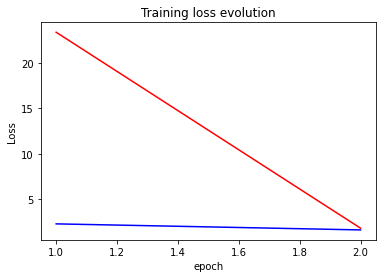

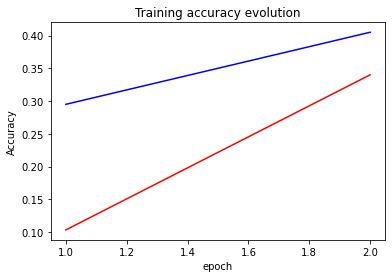

In [5]:
    train_losses = []
    train_accs = []
    test_losses = []
    test_accs = []

    
    
    
    for i in range(epoch):
        print(i)
        if i == 1:
            optimizer = optimizer_sgd
        for images, labels in train_data:
            train_step(images, labels)
        with train_summary_writer.as_default():
            tf.summary.scalar('loss', train_loss.result(), step=i+1)
            tf.summary.scalar('accuracy', train_accuracy.result(), step=i+1)

            
        for images, labels in test_data:
            test_step(images, labels)
        with test_summary_writer.as_default():
            tf.summary.scalar('loss', test_loss.result(), step=i+1)
            tf.summary.scalar('accuracy', test_accuracy.result(), step=i+1)
            tf.summary.scalar('top1error', (1 - test_top1.result())*100, step=i+1)
            tf.summary.scalar('top5error', (1 - test_top5.result())*100, step=i+1)
            

        template = 'Epoch {}, Train Loss: {}, Train Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
        print(template.format(i+1,
                        train_loss.result(),
                        train_accuracy.result()*100,
                        test_loss.result(),
                        test_accuracy.result()*100))

        template = 'Top1 Error: {}, Top5 Error: {}'
        print(template.format((1 - test_top1.result())*100,\
                            (1 - test_top5.result())*100))

        save_path = manager.save()

        train_losses.append(train_loss.result())
        train_accs.append(train_accuracy.result())
        test_losses.append(test_loss.result())
        test_accs.append(test_accuracy.result())

        # Reinicia las metricas para el siguiente epoch.
        train_loss.reset_states()
        train_accuracy.reset_states()
        test_loss.reset_states()
        test_accuracy.reset_states()


    t = np.linspace(1, epoch, num=epoch)
    plot1 = plt.figure(1)
    plt.plot(t, train_losses, 'b')
    plt.plot(t, test_losses, 'r')
    plt.xlabel('epoch')
    plt.ylabel('Loss')
    plt.title('Training loss evolution')
    plt.savefig('./Result_Pics/loss_train')
    plot2 = plt.figure(2)
    plt.xlabel('epoch')
    plt.ylabel('Accuracy')
    plt.plot(t, train_accs, 'b')
    plt.plot(t, test_accs, 'r')
    plt.title('Training accuracy evolution')
    plt.savefig('.//Result_Pics//acc_train')
    plt.show()
    
    a = 1